# Migration Data Analysis and Visualization

## 1. Importing Libraries

In [ ]:
import json
import requests  # For API calls and JSON data
import pandas as pd
import numpy as np  # For data manipulation and analysis
from prophet import Prophet  # For time-series forecasting
import plotly.express as px  # For interactive visualizations
import matplotlib.pyplot as plt
import seaborn as sns

from jupyter_dash import JupyterDash  # Use JupyterDash instead of Dash
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go

## 2. Load and Clean Migration Data

#### 2.1 Load Migration Data

In [ ]:
# Load the first and second halves of refugee data
refugee_data_1 = pd.read_csv('unhcr_data_part1.csv')
refugee_data_2 = pd.read_csv('unhcr_data_part2.csv')
#print(refugee_data_1.head())
#print(refugee_data_2.head())

# Load disaster displacement data
disaster_data = pd.read_csv('IDMC_GIDD_Disasters_Internal_Displacement_Data.csv')
#print(disaster_data.head())

#### 2.2 Clean Refugee Data

In [ ]:
# Convert the 'year' column to numeric
refugee_data_1['Year'] = pd.to_numeric(refugee_data_1['year'], errors='coerce')
refugee_data_2['Year'] = pd.to_numeric(refugee_data_2['year'], errors='coerce')

# Drop unnecessary columns
columns_to_drop = ['coo', 'coo_id', 'coa', 'coa_id', 'returned_refugees', 'returned_idps', 'ooc', 'oip', 'hst']
refugee_data_1 = refugee_data_1.drop(columns=columns_to_drop)
refugee_data_2 = refugee_data_2.drop(columns=columns_to_drop)

# Combine the two datasets
combined_refugee_data = pd.concat([refugee_data_1, refugee_data_2], ignore_index=True)

#### 2.3 Clean Disaster Displacement Data

In [ ]:
# Clean the 'Year' column
disaster_data['Year'] = pd.to_numeric(disaster_data['Year'], errors='coerce')
#print("\nDisaster Data - Year Column After Cleaning")
#print(disaster_data.head())

# Drop unnecessary columns when necessary
#disaster_data = disaster_data.drop(columns=['Event Name', 'Disaster Internal Displacements (Raw)', 'Event Codes (Code:Type)', 'Event ID', 'Displacement occurred'])
#print("\nDisaster Data - After Dropping Unnecessary Columns")

## 3. Load and Clean Climate Data
##### 3.1 Load Temperature and Precipitation Data

In [ ]:
# Load temperature and precipitation data
df_temp = pd.read_excel('cru-x0.5_timeseries_tas_timeseries_monthly_1901-2022_mean_historical_cru_ts4.07_mean.xlsx')
df_precip = pd.read_excel('cru-x0.5_timeseries_pr_timeseries_monthly_1901-2022_mean_historical_cru_ts4.07_mean.xlsx')

#print(df_temp.head())
#print(df_precip.head())

#### 3.2 Transform Climate Data

In [ ]:
# Melt temperature data to long format
df_temp_long = df_temp.melt(id_vars=['code', 'name'], var_name='Date', value_name='Temperature_C')

# Melt precipitation data to long format
df_precip_long = df_precip.melt(id_vars=['code', 'name'], var_name='Date', value_name='Precipitation_mm')

# Convert 'Date' to datetime format
df_temp_long['Date'] = pd.to_datetime(df_temp_long['Date'], format='%Y-%m')
df_precip_long['Date'] = pd.to_datetime(df_precip_long['Date'], format='%Y-%m')

# Unit conversions
df_temp_long['Temperature_F'] = df_temp_long['Temperature_C'] * 9/5 + 32
df_precip_long['Precipitation_in'] = df_precip_long['Precipitation_mm'] / 25.4

# Merge temperature and precipitation data
df_climate = pd.merge(df_temp_long, df_precip_long, on=['code','name', 'Date'], how='inner')


## 4. Load and Clean GDP Data


In [ ]:
data_long = pd.read_csv('GDP.csv'')


print(data.head())

#Data cleaning
data_long = pd.melt(data, id_vars=['Country Name', 'Indicator Name'],
                    var_name='Year', value_name='GDP')

#Data cleaning
data_long['Year'] = pd.to_numeric(data_long['Year'], errors='coerce')

#Data cleaning: dropping NA's
data_long = data_long.dropna(subset=['GDP'])

#Tranposing data lengthwise
print(data_long.head())

## 5. Filtering Data for Consistency

#### 5.1.1  Data Consistency Checks: Country Codes

In [ ]:
# Migration Codes: Collect ISO codes from refugee and disaster data
migration_codes = (
    set(combined_refugee_data['coo_iso'].dropna().unique()) |
    set(combined_refugee_data['coa_iso'].dropna().unique()) |
    set(disaster_data['ISO3'].dropna().unique()))

# Climate Codes: Collect ISO codes from climate data
climate_codes = set(df_climate['code'].dropna().unique())

# Find common ISO codes between migration and climate data
common_codes = migration_codes.intersection(climate_codes)

print(f"Number of common ISO codes: {len(common_codes)}")
print(f"Sample of common ISO codes: {list(common_codes)[:10]}")  # Display first 10 common codes

Number of common ISO codes: 226
Sample of common ISO codes: ['MAR', 'CUB', 'PRK', 'BEN', 'HUN', 'FSM', 'IRN', 'SLE', 'UGA', 'KIR']


#### 5.2 Filter Data Using Common ISO Codes

In [ ]:
# Filter refugee data to include only rows where 'coo_iso' or 'coa_iso' matches a common ISO code
filtered_refugee_data = combined_refugee_data[
    (combined_refugee_data['coo_iso'].isin(common_codes)) |
    (combined_refugee_data['coa_iso'].isin(common_codes)) ]

# Filter disaster data to include only rows where 'ISO3' matches a common ISO code
filtered_disaster_data = disaster_data[disaster_data['ISO3'].isin(common_codes)]

# Filter climate data to include only rows where 'code' matches a common ISO code
filtered_climate_data = df_climate[df_climate['code'].isin(common_codes)]

"""
# Display filtered refugee data sample
print("\nFiltered Refugee Data Sample:")
print(filtered_refugee_data.head())

# Display filtered disaster data sample
print("\nFiltered Disaster Data Sample:")
print(filtered_disaster_data.head())

# Display filtered climate data sample
print("\nFiltered Climate Data Sample:")
print(filtered_climate_data.head())
"""

#will need later in layout
filtered_climate_data['Year'] = filtered_climate_data['Date'].dt.year

C:\Users\zoeis\AppData\Local\Temp\ipykernel_37356\4085485727.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_climate_data['Year'] = filtered_climate_data['Date'].dt.year


In [ ]:
# Merge the refugee and disaster datasets based on ISO and Year
migration_data = pd.merge(
    filtered_refugee_data,
    filtered_disaster_data,
    left_on=['coo_iso', 'Year'],
    right_on=['ISO3', 'Year'],
    how='outer',
    suffixes=('_refugee', '_disaster'))

"""
# Display merged data sample
print("Merged Migration Data Sample:")
print(migration_data.head())

# Display the columns of the merged dataset
print("Merged Data Columns:")
print(migration_data.columns)
"""

'\n# Display merged data sample\nprint("Merged Migration Data Sample:")\nprint(migration_data.head())\n\n# Display the columns of the merged dataset\nprint("Merged Data Columns:")\nprint(migration_data.columns)\n'

## 6. Data Analysis

#### 6.1.1 Data Analysis Migration

In [ ]:
#Number of Countries Represented
print('\nMigration Data: Number of Countries Represented')
num_countries_migration = len(
    set(combined_refugee_data['coo_iso'].dropna().unique()) |
    set(combined_refugee_data['coa_iso'].dropna().unique()) |
    set(disaster_data['ISO3'].dropna().unique()))
print(f"Number of countries: {num_countries_migration}")

#Date Range
print('\nMigration Data: Date Range')
migration_years = migration_years = migration_data['Year'].dropna()
earliest_year_migration = int(migration_years.min())
latest_year_migration = int(migration_years.max())
print(f"Date range: {earliest_year_migration} to {latest_year_migration}")

#Sample Size:
print('\nMigration Data: Sample Size')
num_rows_migration = len(migration_data)
print(f"Total number of rows: {num_rows_migration}")


#Descriptive Statistics: Refugee and Disaster Displacements
print('\nDescriptive Statistics: Refugee Counts')
print(filtered_refugee_data['refugees'].describe())


print('\nDescriptive Statistics: Disaster Displacements')
print(filtered_disaster_data['Disaster Internal Displacements'].describe())


Migration Data: Number of Countries Represented
Number of countries: 232

Migration Data: Date Range
Date range: 1951 to 2023

Migration Data: Sample Size
Total number of rows: 707676

Descriptive Statistics: Refugee Counts
count    1.263530e+05
mean     5.489348e+03
std      6.697499e+04
min      0.000000e+00
25%      5.000000e+00
50%      1.700000e+01
75%      1.520000e+02
max      3.752317e+06
Name: refugees, dtype: float64

Descriptive Statistics: Disaster Displacements
count    1.702700e+04
mean     2.363000e+04
std      2.499338e+05
min      1.000000e+00
25%      2.100000e+01
50%      1.600000e+02
75%      1.400000e+03
max      1.520000e+07
Name: Disaster Internal Displacements, dtype: float64


#### 6.1.2 Data Analysis Climate

In [ ]:
#Number of Countries Represented
print('\nClimate Data: Number of Countries Represented')
num_countries_climate = len(filtered_climate_data['name'].dropna().unique())
print(f"Number of countries: {num_countries_climate}")

#Date Range
print('\nClimate Data: Date Range')
climate_years = filtered_climate_data['Date'].dt.year.dropna()
earliest_year_climate = int(climate_years.min())
latest_year_climate = int(climate_years.max())
print(f"Date range: {earliest_year_climate} to {latest_year_climate}")

#Sample Size:
print('\nClimate Data: Sample Size')
num_rows_climate = filtered_climate_data.shape[0]
print(f"Total number of rows: {num_rows_climate}")


#Descriptive Statistics: Temperature and Precipitation
print('\nDescriptive Statistics: Temperature (°C)')
print(filtered_climate_data['Temperature_C'].describe())


print('\nDescriptive Statistics: Precipitation (mm)')
print(filtered_climate_data['Precipitation_mm'].describe())


Climate Data: Number of Countries Represented
Number of countries: 220

Climate Data: Date Range
Date range: 1901 to 2022

Climate Data: Sample Size
Total number of rows: 330864

Descriptive Statistics: Temperature (°C)
count    330864.000000
mean         19.442386
std           9.818470
min         -35.920000
25%          14.630000
50%          23.410000
75%          26.140000
max          39.420000
Name: Temperature_C, dtype: float64

Descriptive Statistics: Precipitation (mm)
count    330864.000000
mean        103.899195
std         102.223673
min           0.000000
25%          28.510000
50%          71.620000
75%         150.400000
max        1397.140000
Name: Precipitation_mm, dtype: float64


### 6.2 Aggregated Statistics

#### 6.2.1  Top Countries for Migration and Climate Indicators

#### Top 10 Countries by Refugee Origin, Asylum, and Disaster Displacement


Top 10 Refugee Origin Countries:
                 coo_name   refugees
0             Afghanistan  154402630
1                Unknown    94345652
2        Syrian Arab Rep.   63787855
3                    Iraq   28897656
4                 Somalia   25065193
5                Ethiopia   24508457
6                   Sudan   22451952
7             South Sudan   19132212
8                  Angola   17775243
9  Dem. Rep. of the Congo   16858541


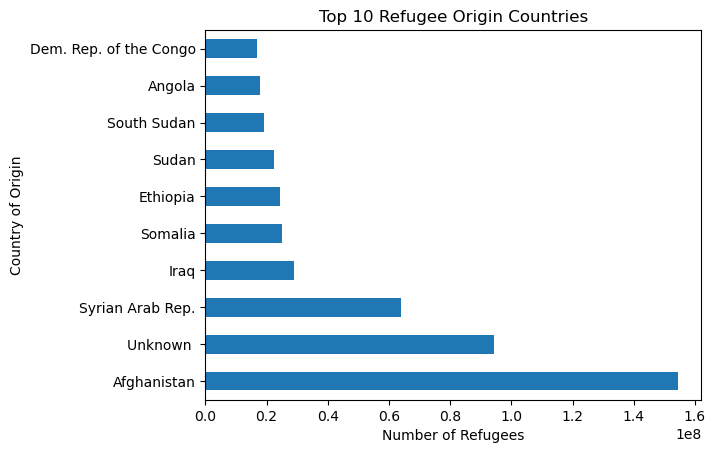

In [ ]:
#  Top 10 Countries by Refugee Origin
print("\nTop 10 Refugee Origin Countries:")
top_origin_countries = combined_refugee_data.groupby('coo_name')['refugees'].sum().nlargest(10).reset_index()
print(top_origin_countries)

# Visualization: Bar chart for top 10 refugee origin countries
top_origin_countries.plot(kind='barh', x='coo_name', y='refugees',
                          title='Top 10 Refugee Origin Countries', legend=False)
plt.xlabel('Number of Refugees')
plt.ylabel('Country of Origin')
plt.show()



Top 10 Refugee Asylum Countries:
                   coa_name  refugees
0                  Pakistan  82006466
1    Iran (Islamic Rep. of)  78675611
2                   Germany  40463645
3  United States of America  34396886
4                   Türkiye  33193266
5                     Sudan  26494742
6    Dem. Rep. of the Congo  26341554
7                    Uganda  20380064
8   United Rep. of Tanzania  17063734
9                  Ethiopia  17061232


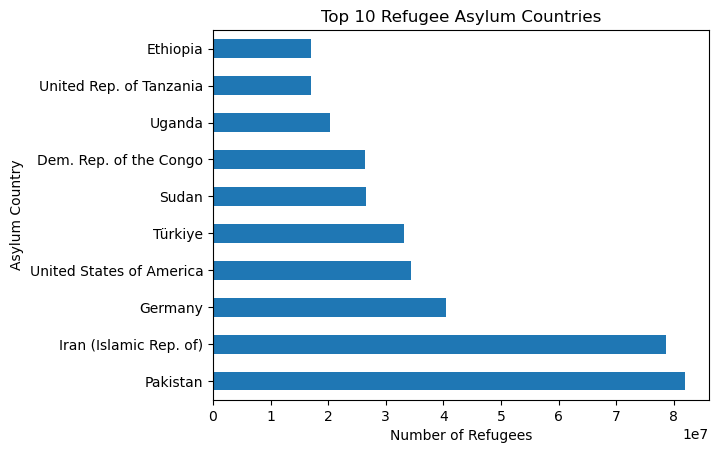

In [ ]:
# Top 10 Countries by Refugee Asylum
print("\nTop 10 Refugee Asylum Countries:")
top_asylum_countries = combined_refugee_data.groupby('coa_name')['refugees'].sum().nlargest(10).reset_index()
print(top_asylum_countries)

# Visualization: Bar chart for top 10 asylum countries
top_asylum_countries.plot(kind='barh', x='coa_name', y='refugees',
                          title='Top 10 Refugee Asylum Countries', legend=False)
plt.xlabel('Number of Refugees')
plt.ylabel('Asylum Country')
plt.show()



Top 10 Countries with Natural Disaster Displacement:
  Country / Territory  Disaster Internal Displacements
0               China                        101377532
1         Philippines                         62177288
2               India                         56446115
3            Pakistan                         25485159
4          Bangladesh                         18833924
5       United States                         11294100
6             Nigeria                          8697100
7           Indonesia                          8066786
8             Myanmar                          7011640
9                Cuba                          6928833


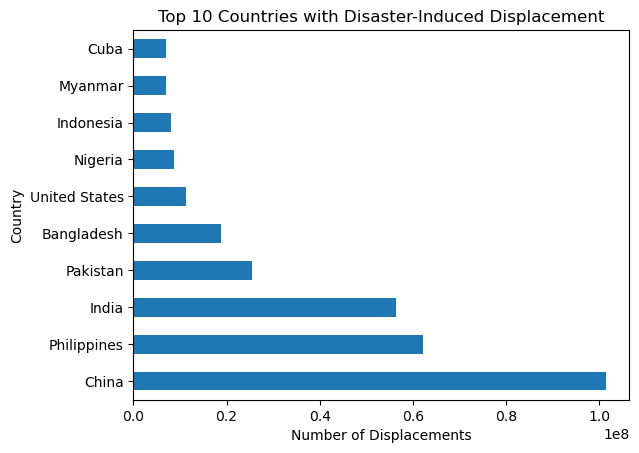

In [ ]:
# Top 10 Countries by Disaster Displacement
print("\nTop 10 Countries with Natural Disaster Displacement:")
top_disaster_countries = filtered_disaster_data.groupby('Country / Territory')['Disaster Internal Displacements'].sum().nlargest(10).reset_index()
print(top_disaster_countries)

# Visualization: Bar chart for top 10 disaster-induced displacement countries
top_disaster_countries.plot(kind='barh', x='Country / Territory', y='Disaster Internal Displacements',
                            title='Top 10 Countries with Disaster-Induced Displacement', legend=False)
plt.xlabel('Number of Displacements')
plt.ylabel('Country')
plt.show()

In [ ]:
### Top 10 Countries by Average Temperature and Precipitation


Top 10 Countries by Average Temperature:
             name  Temperature_C
0    Burkina Faso      28.785041
1            Mali      28.692302
2   Aruba (Neth.)      28.459768
3         Senegal      28.384358
4          Tuvalu      28.356025
5      Mauritania      28.273053
6  Tokelau (N.Z.)      28.186428
7        Djibouti      28.024658
8      The Gambia      27.853757
9           Nauru      27.775478


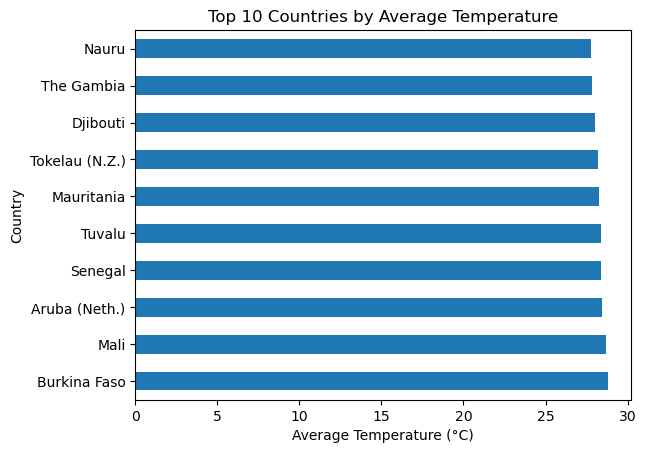

In [ ]:
# Top 10 Countries by Average Temperature
print("\nTop 10 Countries by Average Temperature:")
top_temp_countries = df_climate.groupby('name')['Temperature_C'].mean().nlargest(10).reset_index()
print(top_temp_countries)

# Visualization: Bar chart for top 10 countries by average temperature
top_temp_countries.plot(kind='barh', x='name', y='Temperature_C',
                        title='Top 10 Countries by Average Temperature', legend=False)
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Country')
plt.show()


Top 10 Countries by Average Precipitation:
                             name  Precipitation_mm
0  Federated States of Micronesia        337.416113
1                           Palau        294.833736
2               Brunei Darussalam        269.603798
3                 Solomon Islands        265.374447
4                Papua New Guinea        257.221899
5                           Samoa        251.560526
6         Wallis and Futuna (Fr.)        250.088955
7                        Malaysia        246.242473
8                      Costa Rica        243.053497
9           American Samoa (U.S.)        239.961270


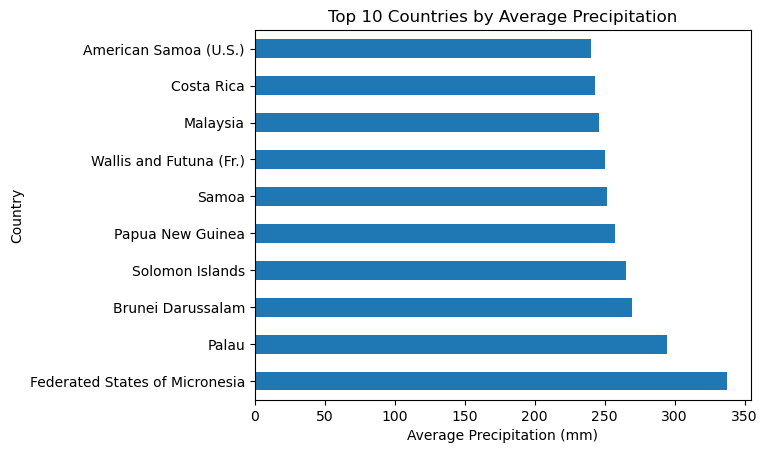

In [ ]:
# Top 10 Countries by Average Precipitation
print("\nTop 10 Countries by Average Precipitation:")
top_precip_countries = df_climate.groupby('name')['Precipitation_mm'].mean().nlargest(10).reset_index()
print(top_precip_countries)

# Visualization: Bar chart for top 10 countries by average precipitation
top_precip_countries.plot(kind='barh', x='name', y='Precipitation_mm',
                          title='Top 10 Countries by Average Precipitation', legend=False)
plt.xlabel('Average Precipitation (mm)')
plt.ylabel('Country')
plt.show()

#### 6.3.1 Yearly Trends for Migration and Climate


Yearly Combined Migration Data:
   Year   refugees  Disaster Internal Displacements
0  1951  1957211.0                              0.0
1  1952  1787928.0                              0.0
2  1953  1679304.0                              0.0
3  1954  1581628.0                              0.0
4  1955  1547066.0                              0.0


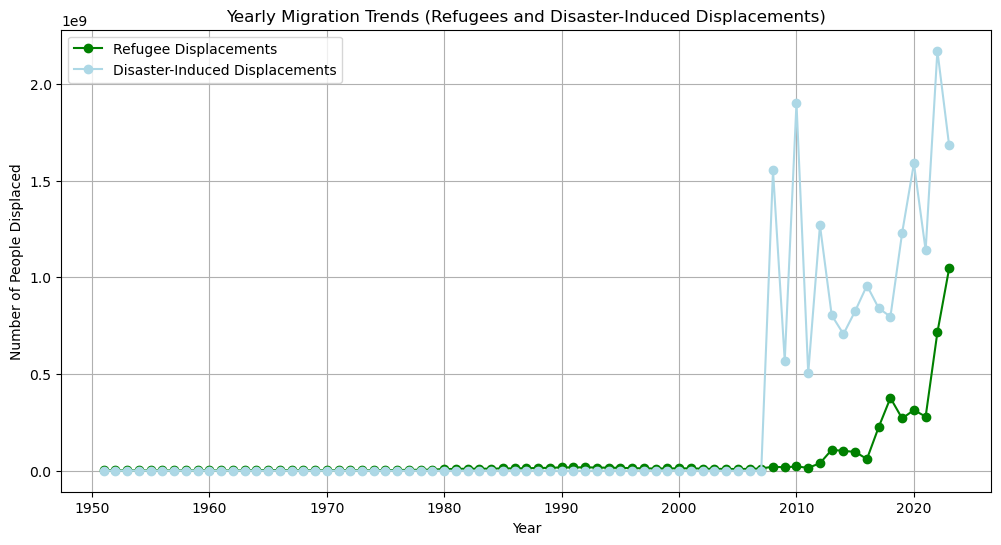

In [ ]:
### Yearly Migration Trends


# Aggregate both refugee and disaster displacement data by year
yearly_migration = migration_data.groupby('Year')[['refugees', 'Disaster Internal Displacements']].sum().reset_index()

print("\nYearly Combined Migration Data:")
print(yearly_migration.head())


# Visualization: Line graphs for average global temperature and precipitation over the years
plt.figure(figsize=(12, 6))

# Line graph for refugees
plt.plot(yearly_migration['Year'], yearly_migration['refugees'], marker='o', linestyle='-', color='green', label='Refugee Displacements')

# Line graph for disaster-induced displacements
plt.plot(yearly_migration['Year'], yearly_migration['Disaster Internal Displacements'], marker='o', linestyle='-', color='lightblue', label='Disaster-Induced Displacements')

# Graph details
plt.title('Yearly Migration Trends (Refugees and Disaster-Induced Displacements)')
plt.xlabel('Year')
plt.ylabel('Number of People Displaced')
plt.legend()
plt.grid(True)
plt.show()



Yearly Temperature and Precipitation Trends:
   Year  Temperature_C  Precipitation_mm
0  1901      18.898183        106.040997
1  1902      18.736776        103.647787
2  1903      18.799740        105.449413
3  1904      18.688723        104.701615
4  1905      18.762855        104.092251


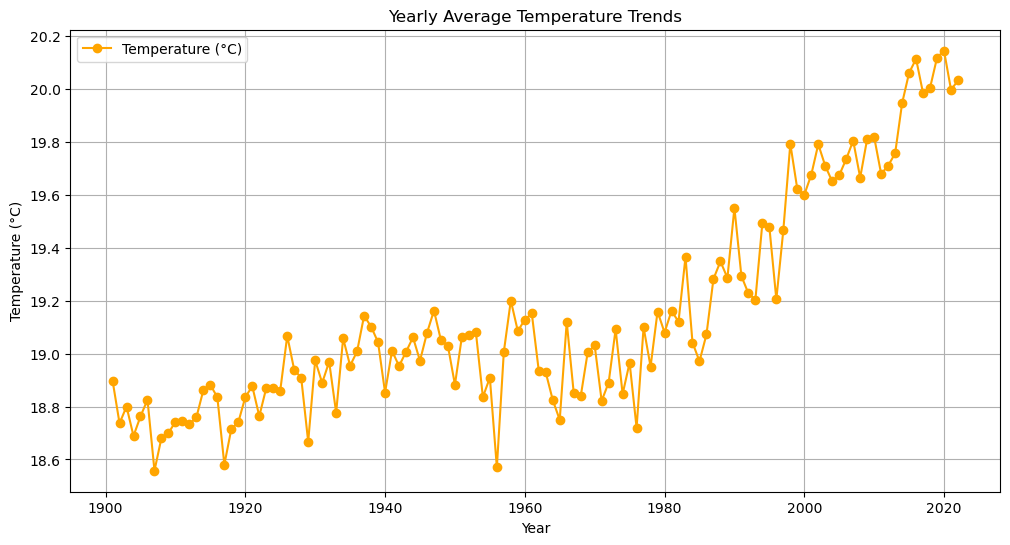

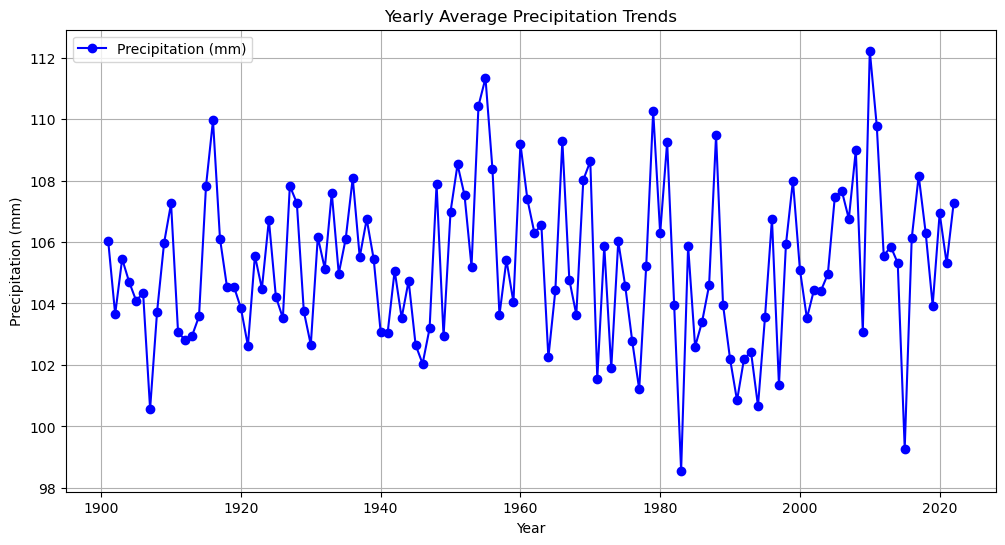

In [ ]:
### Yearly Temperature Trends
# Visualization: Line graphs for average global temperature and precipitation over the years

# Aggregate climate data by year for temperature and precipitation
yearly_climate = df_climate.groupby(df_climate['Date'].dt.year)[['Temperature_C', 'Precipitation_mm']].mean().reset_index()
yearly_climate.rename(columns={'Date': 'Year'}, inplace=True)

print("\nYearly Temperature and Precipitation Trends:")
print(yearly_climate.head())

# Plot the yearly temperature trend
plt.figure(figsize=(12, 6))
plt.plot(yearly_climate['Year'], yearly_climate['Temperature_C'], marker='o', linestyle='-', color='orange', label='Temperature (°C)')

plt.title('Yearly Average Temperature Trends')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()


# Plot the yearly precipitation trend
plt.figure(figsize=(12, 6))
plt.plot(yearly_climate['Year'], yearly_climate['Precipitation_mm'], marker='o', linestyle='-', color='blue', label='Precipitation (mm)')

plt.title('Yearly Average Precipitation Trends')
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.grid(True)
plt.show()



## 7. Building the Dashboard

In [ ]:
# Initialize the Jupyter Dash app
app = Dash(__name__, title="EDA Final Project: Group 17 Dashboard", suppress_callback_exceptions=True)

### 7.2 Define Dashboard Layout

In [ ]:
# Defined Layout of Tabs
app.layout = html.Div([html.H1("Climate Change, Migration, and Economic Impact Dashboard", style={'textAlign': 'center'}),

    # Tabs for different sections
    dcc.Tabs(id='tabs', value='migration', children=[
        dcc.Tab(label='Migration Trends', value='migration'),
        dcc.Tab(label='Climate Trends', value='climate'),
        dcc.Tab(label='Comparison', value='comparison'),]),

    html.Div(id='tabs-content')])

#### 7.2.1 Migration Trends Tab

In [ ]:
def migration_trends_layout():
    return html.Div([html.H2("Migration Trends"),

        # Data Selection Dropdown
        html.Label('Select Displacement Type to Visualize:'),
        dcc.Dropdown(
            id='displacement-dropdown',
            options=[
                {'label': 'Refugees', 'value': 'refugees'},
                {'label': 'Asylum Seekers', 'value': 'asylum_seekers'},
                {'label': 'IDPs', 'value': 'idps'},
                {'label': 'Stateless', 'value': 'stateless'},
                {'label': 'Disaster Internal Displacements', 'value': 'Disaster Internal Displacements'}],
            value=['refugees', 'Disaster Internal Displacements'],
            multi=True),

        # Dropdown for selecting countries
        html.Label("Select Country:"),
        dcc.Dropdown(
            id='migration-country-dropdown',
            options=[{'label': country, 'value': country} for country in migration_data['coo_name'].dropna().unique()],
            value=[migration_data['coo_name'].dropna().unique()[0]],
            multi=True),


        # Year range slider
        html.Label("Select Year Range:"),
        dcc.RangeSlider(
            id='migration-year-slider',
            min=migration_data['Year'].min(),
            max=migration_data['Year'].max(),
            value=[migration_data['Year'].min(), migration_data['Year'].max()],
            marks={str(year): str(year) for year in range(migration_data['Year'].min(), migration_data['Year'].max() + 1, 5)},
            step=1),

    # Buttons for grouping Data; choose how to group the data (by year or country)
        html.Label('Group Data By:'),
        dcc.RadioItems(
            id='group-by-radio',
            options=[
                {'label': 'Group by Year', 'value': 'year'},
                {'label': 'Group by Country', 'value': 'country'}],
            value='year'),


        html.Label('Select Disaster Type:'),
        dcc.Dropdown(
            id='disaster-type-dropdown',
            options=[{'label': dtype, 'value': dtype} for dtype in filtered_disaster_data['Hazard Type'].unique()],
            value=filtered_disaster_data['Hazard Type'].unique()[0],
            clearable=True),

         # Graph placeholder
         dcc.Graph(id='migration-line-graph'),


        # --- Forecasting Section ---
        html.H2("Forecasting"),
        # Country Dropdown for Forecasting
        html.Label('Select Country for Forecasting:'),
        dcc.Dropdown(
            id='forecast-country-dropdown',
            options=[{'label': country, 'value': country} for country in migration_data['coo_name'].dropna().unique()],
            value=[migration_data['coo_name'].dropna().unique()[0]],
            multi=True),  # Allows multiple country selection),

        #Dropdown for Displacement Type
        html.Label('Select Displacement Type for Forecasting:'),
        #dropdown menu for selecting variables to forecast
        dcc.Dropdown(
            id='forecast-displacement-dropdown',
            options=[
                    {'label': 'Refugees', 'value': 'refugees'},
                    {'label': 'Asylum Seekers', 'value': 'asylum_seekers'},
                    {'label': 'IDPs', 'value': 'idps'},
                    {'label': 'Stateless', 'value': 'stateless'},
                    {'label': 'Disaster Internal Displacements', 'value': 'Disaster Internal Displacements'}],
            value='refugees',  # Default selected value for loading of the data
            clearable=False), #ensures a value must be selected

        # Year range slider
        html.Label('Select Forecast Years:'),
        #slider for selecting number of years to forecast
        dcc.Slider(
            id='forecast-year-slider', #unique identifier for slider
            min=1,#min value of slider(in numebr of years)
            max=20,#max value of slider (in number of years)
            value=5, #default value to be set at 5 years
            marks={i: f'{i}' for i in range(1, 21)}, #marks to lable slider intervals
            step=1),

        dcc.Graph(id='forecast-graph')]) # graphs forecast based on user inputs


## 7.2.2 GDP Trends Tab

In [ ]:

#Building layout of the App
app.layout = html.Div([
    html.H1("GDP Forecasting Dashboard"),

    #Creating the dropdown
    html.Label('Select a Country:'),
    dcc.Dropdown(
        id='country-dropdown',
        options=[{'label': country, 'value': country} for country in data['Country Name'].unique()],
        value='United States', #Using U.S. as default country
        clearable=False
    ),

    #Creating the slider tool
    html.Label('Forecast Years:'),
    dcc.Slider(
        id='year-slider',
        min=1,
        max=20,
        value=10,  #default value of 10 year intervals
        marks={i: f'{i}' for i in range(1, 21)},
    ),


    dcc.Graph(id='gdp-forecast-graph')
])

#callback function to update the graph based on dropdown and slider input above
@app.callback(
    Output('gdp-forecast-graph', 'figure'),
    [Input('country-dropdown', 'value'),
     Input('year-slider', 'value')]       #forecast yr
)
def update_forecast(country, years):

    country_data = data[data['Country Name'] == country]

    #Reformatting the columns
    country_data = country_data[['Year', 'GDP']].rename(columns={'Year': 'ds', 'GDP': 'y'})
    country_data['ds'] = pd.to_datetime(country_data['ds'], format='%Y')

    #prophet
    model = Prophet()
    model.fit(country_data)

    #oredictive modeling
    future = model.make_future_dataframe(periods=years, freq='Y')
    forecast = model.predict(future)

    #Using Plotly for real and predictedd data
    fig = go.Figure()


    fig.add_trace(go.Scatter(x=country_data['ds'], y=country_data['y'], mode='lines', name='Actual GDP'))


    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecasted GDP'))

    #Adding confidence interval for predictive trends
    fig.add_trace(go.Scatter(
        x=forecast['ds'], y=forecast['yhat_upper'], fill=None, mode='lines', line_color='lightgrey', name='Upper Bound'
    ))
    fig.add_trace(go.Scatter(
        x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='lines', line_color='lightgrey', name='Lower Bound'
    ))


    fig.update_layout(title=f'GDP Forecast for {country}',
                      xaxis_title='Year',
                      yaxis_title='GDP (current US$)',
                      hovermode='x unified')

    return fig


if __name__ == '__main__':
    app.run_server(debug=True)


#### 7.2.2 Climate Trends Tab

In [ ]:
def climate_trends_layout():
    return html.Div([html.H2("Climate Trends"),

        # Dropdown for selecting countries
        html.Label("Select Country:"),
        dcc.Dropdown(
            id='climate-country-dropdown',
            options=[{'label': country, 'value': country} for country in filtered_climate_data['name'].dropna().unique()],
            value=filtered_climate_data['name'].dropna().unique()[0],
            multi=True),

        # Radio Buttons for Temperature Unit
        html.Label('Select Temperature Unit:'),
        dcc.RadioItems(
            id='temp-unit-radio',
            options=[
                {'label': 'Celsius', 'value': 'C'},
                {'label': 'Fahrenheit', 'value': 'F'}],
            value='C',
            labelStyle={'display': 'inline-block'}),

        # Radio Buttons for Precipitation Unit
        html.Label('Select Precipitation Unit:'),
        dcc.RadioItems(
            id='precip-unit-radio',
            options=[
                {'label': 'Millimeters', 'value': 'mm'},
                {'label': 'Inches', 'value': 'in'}],
            value='mm',
            labelStyle={'display': 'inline-block'}),

        # Year range slider
        html.Label("Select Year Range:"),
        dcc.RangeSlider(
            id='climate-year-slider',
            min=filtered_climate_data['Year'].min(),
            max=filtered_climate_data['Year'].max(),
            value=[filtered_climate_data['Year'].min(), filtered_climate_data['Year'].max()],
            marks={str(year): str(year) for year in range(filtered_climate_data['Year'].min(), filtered_climate_data['Year'].max() + 1, 5)},
            step=1),

        # Line Graphs for Climate Trends
        dcc.Graph(id='temp-graph'),
        dcc.Graph(id='precip-graph'),

        # display analysis
        html.Div(id='analysis-output')])

#### 7.2.3 Comparison Tab

In [ ]:
def comparison_layout():
        # Calculate the intersection of countries in both datasets
    common_countries = list(set(filtered_climate_data['name'].dropna().unique()).intersection(filtered_refugee_data['coo_name'].dropna().unique()))
    if not common_countries:
        common_countries = ['No Common Countries Found']

    return html.Div([html.H2("Comparison of Migration and Climate Data"),

        # Country Selection
        html.Label('Select Country:'),
        dcc.Dropdown(
            id='comparison-country-dropdown',
            options=[{'label': country, 'value': country} for country in common_countries],
            value=common_countries[0] if common_countries else None,
            multi=True),

       # Disaster Type Selection
        html.Label('Select Disaster Type:'),
        dcc.Dropdown(
            id='comparison-disaster-type-dropdown',
            options=[{'label': dtype, 'value': dtype} for dtype in filtered_disaster_data['Hazard Type'].unique()],
            value=filtered_disaster_data['Hazard Type'].unique()[0],
            clearable=True),

       # Temperature Unit Selection
        html.Label('Select Temperature Unit:'),
        dcc.RadioItems(
            id='comparison-temp-unit-radio',
            options=[
                {'label': 'Celsius', 'value': 'C'},
                {'label': 'Fahrenheit', 'value': 'F'}],
            value='C',
            labelStyle={'display': 'inline-block'}),

        # Precipitation Unit Selection
        html.Label('Select Precipitation Unit:'),
        dcc.RadioItems(
            id='comparison-precip-unit-radio',
            options=[
                {'label': 'Millimeters', 'value': 'mm'},
                {'label': 'Inches', 'value': 'in'}],
            value='mm',
            labelStyle={'display': 'inline-block'}),

        # Year Range Slider
        html.Label('Select Year Range:'),
        dcc.RangeSlider(
            id='comparison-year-slider',
            min=min(filtered_climate_data['Date'].dt.year.min(), migration_data['Year'].min()),
            max=max(filtered_climate_data['Date'].dt.year.max(), migration_data['Year'].max()),
            value=[filtered_climate_data['Date'].dt.year.min(), filtered_climate_data['Date'].dt.year.max()],
            marks={str(year): str(year) for year in range(filtered_climate_data['Date'].dt.year.min(), filtered_climate_data['Date'].dt.year.max() + 1, 5)},
            step=1),

        # Graph for Combined Trends
        dcc.Graph(id='comparison-graph')])

In [ ]:
### 7.3 Callbacks

In [ ]:
@app.callback(
    Output('tabs-content', 'children'),
    Input('tabs', 'value'))
def render_content(tab_name):
    if tab_name == 'migration':
        return migration_trends_layout()
    elif tab_name == 'climate':
        return climate_trends_layout()
    elif tab_name == 'comparison':
        return comparison_layout()


In [ ]:
# Migration -- Multi-Variable Graph Callback
@app.callback(
    Output('migration-line-graph', 'figure'),
    [Input('migration-country-dropdown', 'value'),
     Input('displacement-dropdown', 'value'),
     Input('migration-year-slider', 'value'),
     Input('group-by-radio', 'value'),
     Input('disaster-type-dropdown', 'value')])

def update_migration_line_graph(countries, variables, year_range, group_by, disaster_type):
    #Filter data for selected countries and year range
    if isinstance(countries, list) and len(countries) > 0:
        #filter merged data for selected countries in either country of origin or country of asylum
        country_data = migration_data[(migration_data['coo_name'].isin(countries)) | (migration_data['coa_name'].isin(countries))]
    else:
        #if no country is selected, return empty figure
        return go.Figure().add_annotation(text="No country selected", showarrow=False)
    #filter data by selected year range
    country_data = country_data[(country_data['Year'] >= year_range[0]) & (country_data['Year'] <= year_range[1])]


    #Further filter by selected disaster type (if one is selected)
    if disaster_type and 'Hazard Type' in country_data.columns:
        country_data = country_data[country_data['Hazard Type'] == disaster_type]

#Check if there is any data to plot
    if country_data.empty:
        return go.Figure().add_annotation(text="No data available for the selected filters", showarrow=False)

    fig = go.Figure()   #initialize figure for graph

    # Group by selected option (year or country)
    if group_by == 'year':
        #group data by year and sum of variables
        grouped_data = country_data.groupby('Year').sum().reset_index()
        x_axis = 'Year'
    else:
        #group data by country of origin and sum variables
        grouped_data = country_data.groupby('coo_name').sum().reset_index()
        x_axis = 'coo_name'

    # Initialize figure
    fig = go.Figure()

    #Plot each selected variable as bar and line plots to see everythign cohesively
    for variable in variables:
        if variable in grouped_data.columns:
            fig.add_trace(go.Bar(x=grouped_data[x_axis], y=grouped_data[variable], name=f'{variable} (Bar)'))
            fig.add_trace(go.Scatter(x=grouped_data[x_axis], y=grouped_data[variable], mode='lines+markers', name=f'{variable} (Line)'))

    #update figure layout to set visual properties
    fig.update_layout(title=f'Multi-Variable Trends ({group_by.capitalize()})',
        xaxis_title=x_axis.capitalize(),
        yaxis_title='Number of People',
        hovermode='x unified',
        barmode='group')

    return fig

# Migration- Forecast Graph Callback
@app.callback(
    Output('forecast-graph', 'figure'),
    [Input('forecast-country-dropdown', 'value'),
     Input('forecast-displacement-dropdown', 'value'),
     Input('forecast-year-slider', 'value')])

def update_forecast_graph(countries, forecast_variable, forecast_years):
    # Ensure countries are selected
    if not countries:
        return go.Figure().add_annotation(text="No country selected", showarrow=False)

    # Filter data for the selected countries
    country_data = migration_data[(migration_data['coo_name'].isin(countries)) | (migration_data['coa_name'].isin(countries))]

    # Aggregate the data by year for chosen forecast variable
    country_data = country_data.groupby('Year')[forecast_variable].sum().reset_index()
    country_data = country_data.rename(columns={'Year': 'ds', forecast_variable: 'y'})

    # Convert the 'ds' column to datetime format suitable for forecasting
    country_data['ds'] = pd.to_datetime(country_data['ds'], format='%Y')

    # Check if the data is available before modeling
    if country_data.empty:
        fig = go.Figure()
        fig.add_annotation(text="No data available for this selection", showarrow=False)
        return fig


    # Initialize Prophet for time series forecasting
    model = Prophet()
    model.fit(country_data) #fit model with country data

    # Dataframe for specified number of years
    future = model.make_future_dataframe(periods=forecast_years, freq='Y')
    forecast = model.predict(future) #generate forecast

    # Initialize figure and add tracers for actual AND forecasted data
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=country_data['ds'], y=country_data['y'], mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast'))
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill=None, mode='lines', line_color='lightgrey', name='Upper Bound'))
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='lines', line_color='lightgrey', name='Lower Bound'))

    #update layout for better visualization of forecast graph
    fig.update_layout(
        title=f'{forecast_variable.capitalize()} Forecast',
        xaxis_title='Year',
        yaxis_title='Number of People',
        hovermode='x unified')

    return fig


# Climate Data Callback
@app.callback(
    [Output('temp-graph', 'figure'),
     Output('precip-graph', 'figure'),
     Output('analysis-output', 'children')],
    [Input('climate-country-dropdown', 'value'),
     Input('temp-unit-radio', 'value'),
     Input('precip-unit-radio', 'value'),
     Input('climate-year-slider', 'value')])

def update_graphs(selected_countries, temp_unit, precip_unit, selected_years):
    if isinstance(selected_countries, str):
        selected_countries = [selected_countries]

    # filter data for the selected countries
    filtered_data = filtered_climate_data[filtered_climate_data['name'].isin(selected_countries)]

    # filter data by the selected year range
    filtered_data = filtered_data[(filtered_data['Date'].dt.year >= selected_years[0]) & (filtered_data['Date'].dt.year <= selected_years[1])]
    filtered_data['Year'] = filtered_data['Date'].dt.year

    # select user chosen unit (temperature)
    if temp_unit == 'F':
        temp_column = 'Temperature_F'
        temp_label = 'Temperature (°F)'
    else:
        temp_column = 'Temperature_C'
        temp_label = 'Temperature (°C)'

    # select user chosen unit (precipitation)
    if precip_unit == 'in':
        precip_column = 'Precipitation_in'
        precip_label = 'Precipitation (in)'
    else:
        precip_column = 'Precipitation_mm'
        precip_label = 'Precipitation (mm)'

    # create graph for temperature
    temp_fig = px.line(filtered_data, x='Date', y=temp_column, color='name',
                   title="Temperature Trends Through Time (" + temp_label + ")",
                   labels={temp_column: temp_label, 'name': 'Country'})

    # create graph for precipitation
    precip_fig = px.line(filtered_data, x='Date', y=precip_column, color='name',
                     title="Precipitation Trends Through Time (" + precip_label + ")",
                     labels={precip_column: precip_label, 'name': 'Country'})

    # Calculate average temperature/precipitation display
    avg_temp = filtered_data.groupby('name')[temp_column].mean()
    avg_precip = filtered_data.groupby('name')[precip_column].mean()

    # Generate analysis text
    analysis_text = f"Average Temperature and Precipitation from {selected_years[0]} to {selected_years[1]}:\n"
    for country in selected_countries:
        if country in avg_temp and country in avg_precip:
            analysis_text += f"{country}: Avg Temp = {round(avg_temp[country], 2)} {temp_label}, Avg Precip = {round(avg_precip[country], 2)} {precip_label}\n"

    return temp_fig, precip_fig, analysis_text

 #callback function For GDP Data
@app.callback(
    Output('gdp-forecast-graph', 'figure'),
    [Input('country-dropdown', 'value'),
     Input('year-slider', 'value')]       #forecast yr
)
def update_forecast(country, years):

    country_data = data[data['Country Name'] == country]

    #Reformatting the columns
    country_data = country_data[['Year', 'GDP']].rename(columns={'Year': 'ds', 'GDP': 'y'})
    country_data['ds'] = pd.to_datetime(country_data['ds'], format='%Y')

    #prophet
    model = Prophet()
    model.fit(country_data)

    #oredictive modeling
    future = model.make_future_dataframe(periods=years, freq='Y')
    forecast = model.predict(future)

    #Using Plotly for real and predictedd data
    fig = go.Figure()


    fig.add_trace(go.Scatter(x=country_data['ds'], y=country_data['y'], mode='lines', name='Actual GDP'))


    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecasted GDP'))

    #Adding confidence interval for predictive trends
    fig.add_trace(go.Scatter(
        x=forecast['ds'], y=forecast['yhat_upper'], fill=None, mode='lines', line_color='lightgrey', name='Upper Bound'
    ))
    fig.add_trace(go.Scatter(
        x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='lines', line_color='lightgrey', name='Lower Bound'
    ))


    fig.update_layout(title=f'GDP Forecast for {country}',
                      xaxis_title='Year',
                      yaxis_title='GDP (current US$)',
                      hovermode='x unified')

    return fig


if __name__ == '__main__':
    app.run_server(debug=True)


# Comparison Callback
@app.callback(
    Output('comparison-graph', 'figure'),
    [Input('comparison-country-dropdown', 'value'),
     Input('comparison-disaster-type-dropdown', 'value'),
     Input('comparison-temp-unit-radio', 'value'),
     Input('comparison-precip-unit-radio', 'value'),
     Input('comparison-year-slider', 'value')])

def update_comparison_graph(common_countries, displacement_type, disaster_type, temp_unit, precip_unit, year):
    # Check if countries are selected
    if not common_countries:
        return go.Figure().add_annotation(text="No country selected", showarrow=False)

    if year_range is None:
        year_range = [filtered_climate_data['Date'].dt.year.min(), filtered_climate_data['Date'].dt.year.max()]

    year_range = [int(year) for year in year_range]

    # Filter migration data based on selected countries, disaster type, and year range
    migration_filtered = migration_data[(migration_data['coo_name'].isin(common_countries)) & (migration_data['Hazard Type'] == disaster_type) &
        (migration_data['Year'] >= year_range[0]) & (migration_data['Year'] <= year_range[1])]

    # Filter climate data based on selected countries and year range
    climate_filtered = filtered_climate_data[(filtered_climate_data['name'].isin(common_countries)) & (filtered_climate_data['Date'].dt.year >= year_range[0]) & (filtered_climate_data['Date'].dt.year <= year_range[1])]


    # Convert temperature to selected unit
    climate_filtered = climate_filtered.copy()
    if temp_unit == 'F':
        climate_filtered['Temperature'] = climate_filtered['Temperature_C'] * 9/5 + 32
        temp_label = 'Temperature (°F)'
    else:
        climate_filtered['Temperature'] = climate_filtered['Temperature_C']
        temp_label = 'Temperature (°C)'

    # Convert precipitation to selected unit
    if precip_unit == 'in':
        climate_filtered['Precipitation'] = climate_filtered['Precipitation_mm'] / 25.4
        precip_label = 'Precipitation (in)'
    else:
        climate_filtered['Precipitation'] = climate_filtered['Precipitation_mm']
        precip_label = 'Precipitation (mm)'

    # Initialize figure
    fig = go.Figure()

    # Plot migration data (Refugees and IDPs)
    if not migration_filtered.empty:
        fig.add_trace(go.Scatter(x=migration_filtered['Year'], y=migration_filtered['refugees'], mode='lines+markers', name='Refugees', line=dict(color='green')))

    if not migration_filtered.empty:
        fig.add_trace(go.Scatter(x=migration_filtered['Year'], y=migration_filtered['Disaster Internal Displacements'], mode='lines+markers', name='Disaster Displacements', line=dict(color='red')))

    # Plot climate data (Temperature)
    if not climate_filtered.empty:
        fig.add_trace(go.Scatter(x=climate_filtered['Year'], y=climate_filtered['Temperature'], mode='lines', name=temp_label, line=dict(color='orange')))

    # Plot climate data (Precipitation)
    if not climate_filtered.empty:
        fig.add_trace(go.Scatter(x=climate_filtered['Year'], y=climate_filtered['Precipitation'], mode='lines', name=precip_label, line=dict(color='blue')))

    # Update figure layout for clarity
    fig.update_layout(
        title='Comparison of Migration and Climate Data', xaxis_title='Year', yaxis_title='Values', hovermode='x unified',
        legend=dict(x=0, y=1, traceorder='normal'))

    return fig

#### 8.4 Run the Jupyter Dash App

In [ ]:
# Run the app in Jupyter Notebook
if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)

In [ ]:
# 7.

# 9. Conclusions and Future Work

# 10. References